In [1]:
import numpy as np 
import h5py
import matplotlib.pyplot as plt
from astropy import units
# %matplotlib ipympl

In [2]:
GIZd = h5py.File('./data/GIZ-profiles-progenitors_myevoz.hdf5','r')
G3Xd = h5py.File('./data/G3X-profiles-progenitors_myevoz.hdf5','r')

In [6]:

'''
calculate median profiles and percentile error [16,84] statistically

mod: simulation name [GIZMO or GadgetX]
d: simulation data
snap: which snapshot (equally redshift)
region: which property
ntclu: total cluster number (few clusters may not form at high redshift)
part: which particle part (default 0, this is not meaning DM particles)
'''

def cal_median(rbin, value, nbin):
    xmed = np.zeros(nbin)
    ymed = np.zeros(nbin)
    yerr = np.zeros(shape = (2,nbin))
    
    #calculate the median profile
    for j in range(nbin):
#         nonan = np.where((value[:,j]!= 0) & (np.isnan(value[:,j]) == False))[0]
        nonan = np.where((np.isnan(value[:,j]) == False))[0]
        if len(nonan) > 1:
            ymed[j] = np.median(value[nonan,j])
            xmed[j] = np.median(rbin[nonan,j])
            yerrtot = np.percentile(value[nonan,j],[16,84])
            yerr[0,j] = yerrtot[0]
            yerr[1,j] = yerrtot[1]
    return xmed,ymed,yerr

def cal_sta_profiles(mod,d,snap,region,bin25,ntclu,part = 0):
    nbin = 50
    allvalue=np.zeros(shape = (ntclu,nbin))
    rbinvalue=np.zeros(shape = (ntclu,nbin))
    npvalue=np.zeros(shape = (ntclu,nbin))
    
    redshift = d['NewMDCLUSTER_0001/snap_%03d'%(snap)].attrs['redshift']
    print(redshift)
    Ez = (0.307*(1 + redshift)**3 + 0.693)**0.5
    fb = 0.15 #baryon fraction: Omega_M / Omega_b
    mu = 0.5994 #mean molecular weight
    mue = 1.1548 #mean molecular mass per electron
    i = 0
    #read raw data
    for nclu in range(324):
        if 'Rbin' not in d['NewMDCLUSTER_0%03d/snap_%03d'%(nclu+1, snap)]:          
            continue
        M500 = d['NewMDCLUSTER_%04d/snap_%03d'%(nclu+1,snap)].attrs['M500']
        r500 = d['NewMDCLUSTER_%04d/snap_%03d'%(nclu+1,snap)].attrs['r500']
        
        #Gihirardini+2021
#         P500 = 3.426*1e-3*(M500 / 1e15 / 0.7)**(2/3) * Ez**(8/3) * (fb/0.16) * (mu/0.6) * (mue/1.14)
#         P500 = 3.426*1e-3*(M500 / 1e15 / 0.7)**(2/3) * Ez**(8/3)
        #Voit2005
#         P500 = 1.65*1e-3 * (M500 / 0.6777 / 3e14) * Ez**(8/3)
        #Planelles+2017
        keVtoerg = (units.keV).to('erg') 
        P500 = (M500 / 1e15)**(2/3) * 1.45e-11 * Ez**(8/3) / keVtoerg #P500 in units: erg*cm^-3

        allvalue[i] = d['NewMDCLUSTER_%04d/snap_%03d/%s'%(nclu+1,snap,region)][:] * 0.6777**3 / P500
        rbinvalue[i] = d['NewMDCLUSTER_%04d/snap_%03d/Rbin'%(nclu+1,snap)][:] / r500 #unit: r/r500
        npvalue[i] = d['NewMDCLUSTER_%04d/snap_%03d/NuminBin'%(nclu+1,snap)][0]
        i+=1
    print(i)
    
                
#     if region == 'Pressure':
#         from astropy import units
#         keVtoerg = (units.keV).to('erg') 
#         if model == 'G3X': m500 * 1e10
#         p500 = (allm500 / 1e15 / 0.7)**(2/3) * 1.45e-11  #P500 in units: erg*cm^-3
#         p500 = p500.reshape(ntclu,1)
#         allvalue = allvalue * 0.6777**3 * keVtoerg / p500

    allvalue =  allvalue * (1+redshift)**3
    #calculate the median profile
    if bin25 == True:
        # combine nearby bins with near 2
        rbin25 = np.zeros(shape = (ntclu, 25))
        value25 = np.zeros(shape = (ntclu, 25))
        np25 = np.zeros(shape = (ntclu, 25))
        for i in range(ntclu):
            for j in range(25):
                bin0 = j*2
                bin1 = j*2+1
                value25[i,j] = (allvalue[i,bin0] + allvalue[i,bin1]) / 2
                rbin25[i,j] = (rbinvalue[i,bin0] + rbinvalue[i,bin1]) / 2
                np25[i,j] = npvalue[i,bin0] + npvalue[i,bin1]
        
        np_med = np.median(np25, axis = 0)
        np25 = np.sum(np25, axis = 1)
        idnp = np.where(np25 >= 50)[0]
        print('input sample is', idnp.shape[0])
        xmed,ymed,yerr = cal_median(rbin25[idnp], value25[idnp], 25)
        return xmed,ymed,yerr,np_med
    else:       
        np_med = np.median(npvalue, axis = 0)
        npvalue = np.sum(npvalue, axis = 1)
        idnp = np.where(npvalue >= 50)[0]
        print('input sample is', idnp.shape[0])
        xmed,ymed,yerr =  cal_median(rbinvalue[idnp], allvalue[idnp], 50)
        return xmed,ymed,yerr,np_med

In [4]:
def ob_Pressure(ax):
    #Ghirardini+2021
    G2021 = np.loadtxt(open('./data/ob_Pressure/Ghirardini+2021.csv', 'r'),delimiter = ',')
    ob1, = ax.plot(G2021[:,0], G2021[:,1], color = 'grey', ls = '-', label = 'Ghirardini+2019 (z < 0.1)',zorder = -1)
    
    #---------------------------------------------
    #Ghirardini+2017 (0.7,1.2)
    def P_P500(xx,P0,c500,gama,alpha,beta):
        return P0 / ((c500*xx)**gama*(1 + (c500*xx)**alpha)**((beta-gama)/alpha))
    xx = np.linspace(0,1,100)
#     #0.4 < z < 0.52
#     y1 = P_P500(xx,9.1,1.08,0.308,0.87,5.49)
#     ax.plot(xx,y1,lw = 2, ls = '-.', c = 'blue', label = 'Ghirardini+2017 (0.4<z<0.52)')
    #0.52 < z < 0.77
    y1 = P_P500(xx,9.2,1.48,0.308,1.11,5.49)
    ob2, = ax.plot(xx,y1,lw = 2, ls = '--', c = 'grey', alpha = 0.8, label = 'Ghirardini+2017 (0.52 < z < 0.77)',zorder = -1)  
    #0.77 < z < 1.2
    y1 = P_P500(xx,9.1,1.08,0.308,0.87,5.49)
    ob3, = ax.plot(xx,y1,lw = 2, ls = '--', c = 'grey', alpha = 0.4, label = 'Ghirardini+2017 (0.77 < z < 1.2)', zorder = -1)
    
    #----------------------------------------------
#     #Nagai+2007: 'universal pressure profile' from G+2017
#     y = P_P500(xx,8.403,1.177,0.3081,1.0510,5.49)
#     ax.plot(xx,y,lw = 2, ls = '-.', c = 'k', label = 'Nagai+2017(universal)')
    
    
    #----------------------------------------------
    #McDonald+2014
    xx = np.array([0,0.04,0.08,0.13,0.20,0.28,0.36,0.46,0.58,0.74,0.95,1.2,1.5])
    xxm = (xx[1:] + xx[:-1])/2
    xxl = xxm - xx[:-1]
    xxr = xx[1:] - xxm
    
    # 0.3 < z < 0.6
    y1 = np.array([10.37,6.58,5.17,3.81,2.60,1.73,1.14,0.69,0.43,0.22,0.11,0.06])
    y1errup = np.array([3.44,0.94,0.61,0.28,0.20,0.07,0.04,0.03,0.02,0.02,0.01,0.01])
    y1errdown = np.array([2.44,1.09,0.52,0.23,0.15,0.05,0.05,0.03,0.02,0.01,0.01,0.01])
#     ax.errorbar(xxm, y1, xerr = [xxl, xxr], yerr = [y1errdown, y1errup], color = 'grey',
#                  fmt = 'none', lw =2,label = 'McDonald+2014 (0.3<z<0.6)', zorder = -1, alpha = 1)

    # 0.6 < z < 1.2
    y2 = np.array([5.69,4.30,3.92,3.32,2.57,1.81,1.16,0.67,0.40,0.19,0.08,0.04])
    y2errup = np.array([0.86,0.53,0.40,0.32,0.23,0.10,0.05,0.03,0.02,0.01,0.01,0.01])
    y2errdown = np.array([0.90,0.51,0.57,0.30,0.19,0.11,0.04,0.03,0.02,0.01,0.01,0.01])
#     ax.errorbar(xxm, y2, xerr = [xxl, xxr], yerr = [y2errdown, y2errup], color = 'cyan',
#                  fmt = 'none', lw =2,label = 'McDonald+2014 (0.6<z<1.2)', zorder = -1, alpha = 1)
    
    for i in range(xx.shape[0]-1):
        xx0 = np.linspace(xx[i],xx[i+1],100)
        if i == 0:
            ob4 = ax.fill_between(xx0,y1[i] - y1errdown[i], y2[i] + y2errup[i], label = 'McDonald+2014 (0.3 < z < 0.6)',
                         hatch = '\\\\',color = 'grey', facecolors = 'none',alpha = 0.8, zorder = 50)
            ob4.set_facecolor('none')
        else:
            sc = ax.fill_between(xx0,y1[i] - y1errdown[i], y2[i] + y2errup[i],
                         hatch = '\\\\',color = 'grey', facecolors = 'none',alpha = 0.8, zorder = 50)
            sc.set_facecolor('none')
            
        if i == 0:
            ob5 = ax.fill_between(xx0,y2[i] - y2errdown[i], y2[i] + y2errup[i], label = 'McDonald+2014 (0.6 < z < 1.2)',
                         hatch = '////',color = 'grey', facecolors = 'none',alpha = 0.4, zorder = 50)
            ob5.set_facecolor('none')
        else:
            sc = ax.fill_between(xx0,y2[i] - y2errdown[i], y2[i] + y2errup[i],
                         hatch = '////',color = 'grey', facecolors = 'none',alpha = 0.4, zorder = 50)
            sc.set_facecolor('none')
            
    # #----------------------------
    # #Sayers et al. 2013
    # C500 = 1.18
    # alpha = 0.86
    # beta = 3.67
    # gamma = 0.67
    # P0 = 4.29
    # xx = np.linspace(0.06,1.8,200)
    # yy = P0 / ((C500*xx)**gamma*(1 + (C500*xx)**alpha)**((beta-gamma)/alpha))
    # ax.plot(xx,yy, lw = 2.2, ls = ':', c = 'grey', label = 'Sayers+2013 (0.15$\leq$z$\leq$0.89)', zorder = -1)
    
    # Sayers et al. 2022
    # mean pressure
    xx = [0.028, 0.047, 0.078, 0.13, 0.22, 0.36, 0.60, 1.0, 1.7]
    y_low_z = [1.94e1, 1.47e1, 1.10e1, 7.16, 3.91, 1.79, 7.29e-1, 1.79e-1, 3.87e-2]
    y_high_z = [3.68e1, 2.78e1, 1.93e1, 1.07e1, 5.76, 2.33, 9.48e-1, 1.71e-1, 1.59e-2]
    ob6, = ax.plot(xx, y_low_z, 'o', c = 'grey', label = 'Sayers+2022 ($z_{med}$ = 0.08)', zorder = 500)
    # ax.plot(xx, y_high_z, 's', c = 'grey', label = 'Sayers+2013 ($z_{med}$ = 0.50)', zorder = -1)


    # #McDonald+2014 (0.46,0.82)
    # def P_P500_fit(xx,P0,c500,gama,alpha,beta,fM):
    #     return P0 * (c500*xx)**(-gama)*(1 + (c500*xx)**alpha)**(-(beta-gama)/alpha) * fM
    # xx = np.linspace(0,1.5,100)
    # #z ~ 0.46
    # y1 = P_P500_fit(xx,4.33,2.59,0.26,1.63,3.30,1.07)
    # ax.plot(xx,y1,lw = 2.5, ls = '-', c = 'k', alpha = 0.8, label = 'McDonald+2014 (z~0.46)',zorder = -1)  
    # #z ~ 0.82
    # y1 = P_P500_fit(xx,3.47,2.59,0.15,2.27,3.48,1.034)
    # ax.plot(xx,y1,lw = 2.5, ls = ':', c = 'k', alpha = 0.4, label = 'McDonald+2014 (z~0.82)', zorder = -1)
    return ob1, ob2, ob3, ob4, ob5, ob6
# plt.figure(dpi = 100)
# ax = plt.gca()
# ob_Pressure(ax)
# plt.loglog()
# plt.legend()

0.0
324
input sample is 324
0.0
324
input sample is 324
0.0
324
input sample is 324
0.0
324
input sample is 324
1.030549168586731
324
input sample is 324
1.030549168586731
324
input sample is 324
2.0213561058044434
323
input sample is 323
2.0213561058044434
324
input sample is 324
3.0278635025024414
323
input sample is 323
3.0278635025024414
323
input sample is 323
4.017714977264404
323
input sample is 317
4.017714977264404
323
input sample is 302


/home/qyli/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/qyli/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


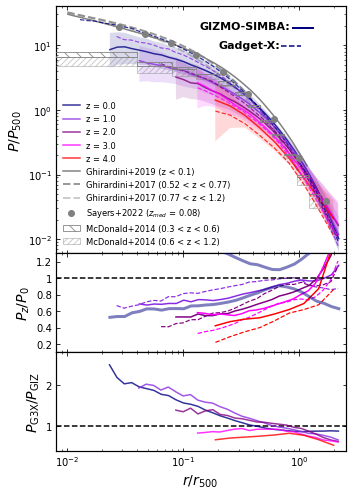

In [7]:
#Combined results
from astropy.cosmology import FlatLambdaCDM
plt.figure(figsize = (5,7))
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1.2 #set the value globally
cosmo = FlatLambdaCDM(H0=67.77, Om0=0.307115)

#divide grids for figure
ax1 = plt.subplot2grid((9,4),(0,0),colspan = 4,rowspan = 5)
ax10 = plt.subplot2grid((9,4),(5,0),colspan = 4,rowspan = 2)
ax20 = plt.subplot2grid((9,4),(7,0),colspan = 4,rowspan = 2)


snapb = [128,96,78,65,55,47,40]
redb = ['z = 0.0','z = 1.0','z = 2.0','z = 3.0','z = 4.0','z = 5.0','z = 6.0']
# colall = ['b','r','k','orange','cyan','magenta','green']
colall = ['navy','blueviolet','purple','magenta','r','tomato','orange']
nGIZ = [324,324,323,323,323,318,306]
nG3X = [324,324,324,323,323,320,305]
idtGIZ = [37,31,26,21,9,7,7]
idtG3X = [37,33,27,21,8,8,9]
#==========================================================

# GIZMO
#Gadget-X      
for i in [0,1,2,3,4]:
    if i == 0:
        xmed0,ymed0,yerr0,np_med0 = cal_sta_profiles('GIZ',GIZd,snapb[i],'Pressure',False,nGIZ[i])
        xmed25,ymed25,yerr25,np_med25 = cal_sta_profiles('GIZ',GIZd,snapb[i],'Pressure',True,nGIZ[i])
        idt = np.where(np_med0 >= 10)[0]
        sim0, = ax1.plot(xmed0[idt],ymed0[idt],lw = 1.5, label = redb[i],c=colall[i],zorder = 20, alpha=0.8)
        ax1.fill_between(xmed0[idt],yerr0[0,idt],yerr0[1,idt],color = colall[i],alpha = 0.15, edgecolor = 'none')
        ax10.plot(xmed0[idt],yerr0[0,idt]/ymed0[idt],lw = 3, c='navy', ls = '-', alpha = 0.5, zorder = 500)
        ax10.plot(xmed0[idt],yerr0[1,idt]/ymed0[idt],lw = 3, c='navy', ls = '-', alpha = 0.5, zorder = 500)
        
        xmed0_x,ymed0_x,yerr0_x,np_med0_x = cal_sta_profiles('G3X',G3Xd,snapb[i],'Pressure',False,nG3X[i])
        xmed25_x,ymed25_x,yerr25_x,np_med25_x = cal_sta_profiles('G3X',G3Xd,snapb[i],'Pressure',True,nG3X[i])
        idt_x = np.where(np_med0_x >= 10)[0]
        ax1.plot(xmed0_x[idt_x],ymed0_x[idt_x],lw = 1.2, ls = '--',  c=colall[i], zorder = 30,alpha = 0.8)
        
        if len(idt_x) <= len(idt):
            ax20.plot(xmed0_x[idt_x],ymed0_x[idt_x]/ymed0[idt_x], c=colall[i], zorder = 30,alpha = 0.8)
        else:
            ax20.plot(xmed0_x[idt],ymed0_x[idt]/ymed0[idt], c=colall[i], zorder = 30,alpha = 0.8)
    elif i <= 3:
        xmed,ymed,yerr,np_med = cal_sta_profiles('GIZ',GIZd,snapb[i],'Pressure',False,nGIZ[i])
        idt = np.where(np_med >= 10)[0]
        if i == 1:
            sim1, = ax1.plot(xmed[idt],ymed[idt],lw = 1.5, label = redb[i],c=colall[i],zorder = 20, alpha = 0.8)
        elif i == 2:
            sim2, = ax1.plot(xmed[idt],ymed[idt],lw = 1.5, label = redb[i],c=colall[i],zorder = 20, alpha = 0.8)
        else:
            sim3, = ax1.plot(xmed[idt],ymed[idt],lw = 1.5, label = redb[i],c=colall[i],zorder = 20, alpha = 0.8)

        ax1.fill_between(xmed[idt],yerr[0,idt],yerr[1,idt],color = colall[i],alpha = 0.15, edgecolor = 'none')
        ax10.plot(xmed[idt],ymed[idt]/ymed0[idt],lw = 1.5, c=colall[i])
        
        xmed_x,ymed_x,yerr_x,np_med_x = cal_sta_profiles('G3X',G3Xd,snapb[i],'Pressure',False,nG3X[i])
        idt_x = np.where(np_med_x >= 10)[0]
        ax1.plot(xmed_x[idt_x], ymed_x[idt_x], lw = 1.2, ls = '--', c=colall[i], zorder = 30, alpha = 0.8)
        ax10.plot(xmed_x[idt_x], ymed_x[idt_x]/ymed0_x[idt_x],c=colall[i], lw = 1.2, ls = '--')
        
        if len(idt_x) <= len(idt):
            ax20.plot(xmed_x[idt_x],ymed_x[idt_x]/ymed[idt_x], c=colall[i], zorder = 30,alpha = 0.8)
        else:
            ax20.plot(xmed_x[idt],ymed_x[idt]/ymed[idt], c=colall[i], zorder = 30,alpha = 0.8)
    else:
        xmed,ymed,yerr,np_med = cal_sta_profiles('GIZ',GIZd,snapb[i],'Pressure',True,nGIZ[i])
        idt = np.where(np_med >= 10)[0]
        sim4, = ax1.plot(xmed[idt],ymed[idt],lw = 1.5, label = redb[i],c=colall[i],zorder = 20, alpha = 0.8)
        ax1.fill_between(xmed[idt],yerr[0,idt],yerr[1,idt],color =colall[i],alpha = 0.15, edgecolor = 'none')
        ax10.plot(xmed[idt],ymed[idt]/ymed25[idt],lw = 1.5, c=colall[i])
        
        xmed_x,ymed_x,yerr_x,np_med_x = cal_sta_profiles('G3X',G3Xd,snapb[i],'Pressure',True,nG3X[i])
        idt_x = np.where(np_med_x >= 10)[0]
        ax1.plot(xmed_x[idt_x], ymed_x[idt_x], lw = 1.2, ls = '--', c=colall[i], zorder = 30, alpha = 0.8)
        ax10.plot(xmed_x[idt_x],ymed_x[idt_x]/ymed25_x[idt_x],c=colall[i], lw = 1.2, ls = '--')
        
        if len(idt_x) <= len(idt):
            ax20.plot(xmed_x[idt_x],ymed_x[idt_x]/ymed[idt_x], c=colall[i], zorder = 30,alpha = 0.8)
        else:
            ax20.plot(xmed_x[idt],ymed_x[idt]/ymed[idt], c=colall[i], zorder = 30,alpha = 0.8)
    
ax1.text(0.138,1.8e1,'GIZMO-SIMBA:',weight = 'bold',size = 11) 
ax1.text(0.2,0.9e1,'Gadget-X:',weight = 'bold',size = 11) 

from matplotlib.lines import Line2D
lin1 = Line2D([],[],c = 'navy',lw = 2)
legend2 = ax1.legend(handles=[lin1],frameon = False, loc = (0.805,0.875))
ax1.add_artist(legend2)

lin0 = Line2D([],[],c = 'navy',lw = 1.5, ls = '--')
legend0 = ax1.legend(handles=[lin0],frameon = False, loc = (0.765,0.80))
ax1.add_artist(legend0)

ob1, ob2, ob3, ob4, ob5, ob6 = ob_Pressure(ax1)

# legend1 = ax1.legend(handles=[ob1, ob6, ob2, ob3, ob4, ob5],loc = (0.23,0.02), fontsize = 'small',frameon = False)
# ax1.add_artist(legend1) #first legend
# ax1.legend(handles = [sim0,sim1,sim2,sim3,sim4], loc = (0.02,0.08), fontsize = 'small',ncol = 1, frameon = False)
ax1.legend( loc = 3, fontsize = 'small',ncol = 1, frameon = False)
#==========================================================================
# ax10.grid(c = 'grey', ls = '--', alpha = 0.5)
ax10.axhline(1,c='k',ls='--')

ax1.set_ylabel(r'$P/P_{500}$', fontsize = 14)
ax1.loglog()
ax1.set_xticklabels([])
ax1.set_ylim(6e-3,4e1)
ax1.set_xlim(0.008,2.5)
# ax1.grid(c = 'grey', ls = '--', alpha = 0.5)
ax10.set_xscale('log')
ax10.set_xlim(0.008,2.5)
ax10.set_xlabel(r'$r/r_{500}$', fontsize = 14)
ax10.set_ylabel(r'$P_z/P_0$', fontsize = 14)
ax10.set_ylim(0.1,1.3)
ax10.set_yticks([0.2,0.4,0.6,0.8,1,1.2])
ax10.set_yticklabels([0.2,0.4,0.6,0.8,1,1.2])

ax20.axhline(1,c='k',ls='--')
ax20.set_xscale('log')
ax20.set_xlim(0.008,2.5)
ax20.set_ylim(0.4,2.8)
ax20.set_xlabel(r'$r/r_{500}$', fontsize = 14)
ax20.set_ylabel(r'$P_{\rm G3X}/P_{\rm GIZ}$', fontsize = 14)
ax20.tick_params(top = 'on', right = 'on', which='both',direction = 'in',labelsize = 10)

ax1.tick_params(top = 'on', right = 'on', which='both',direction = 'in', labelsize = 10)
ax10.tick_params(top = 'on', right = 'on', which='both',direction = 'in', labelsize = 10)
plt.tight_layout()
plt.subplots_adjust(wspace = 0, hspace = 0)

plt.savefig('./figsv2/Pressure.pdf')

<IPython.core.display.Javascript object>


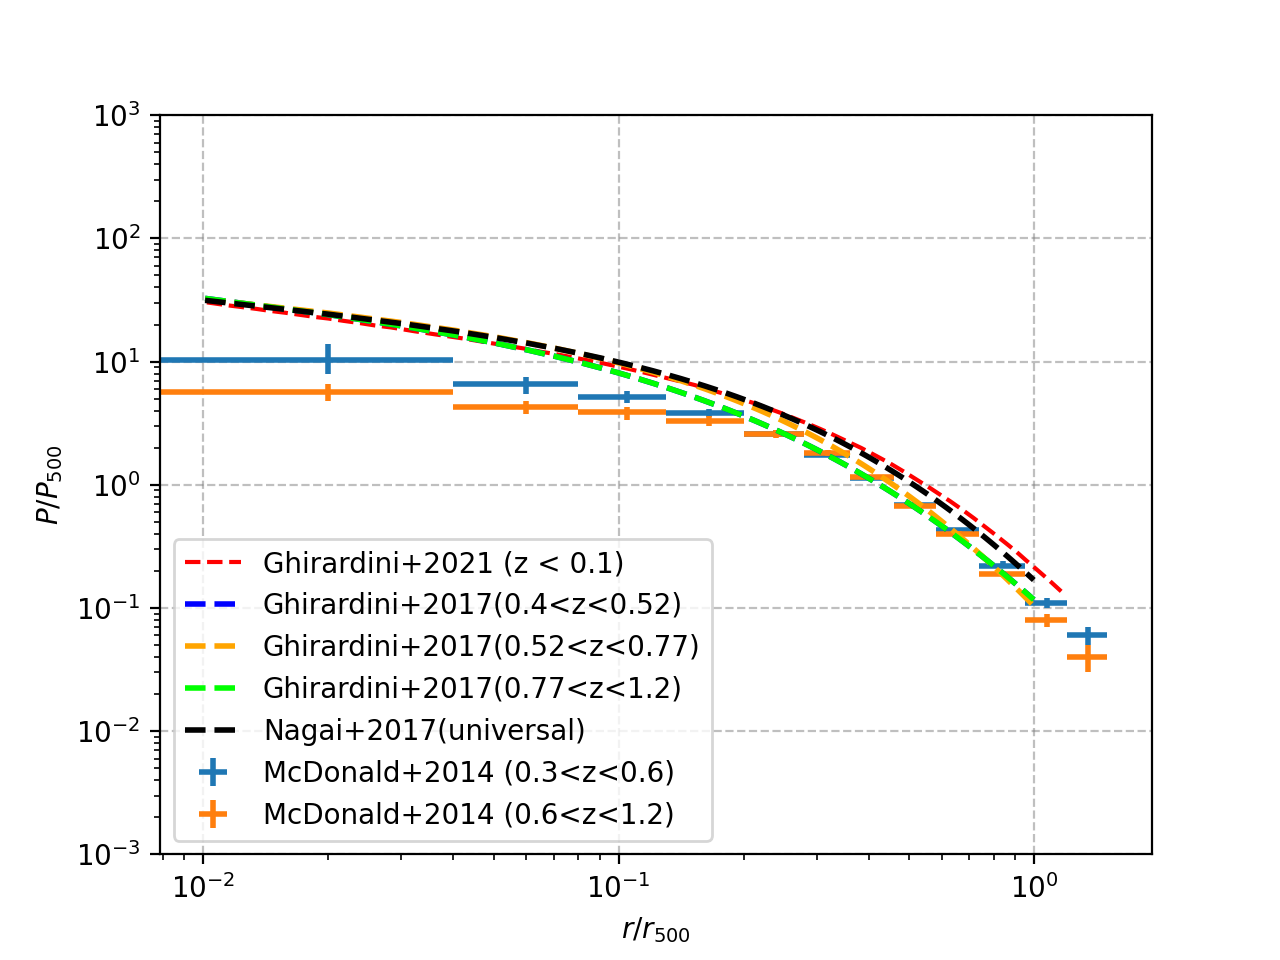

<ipython-input-83-a57ebb52776f>:9: RuntimeWarning: divide by zero encountered in true_divide
  return P0 / ((c500*xx)**gama*(1 + (c500*xx)**alpha)**((beta-gama)/alpha))
<ipython-input-83-a57ebb52776f>:9: RuntimeWarning: divide by zero encountered in true_divide
  return P0 / ((c500*xx)**gama*(1 + (c500*xx)**alpha)**((beta-gama)/alpha))
<ipython-input-83-a57ebb52776f>:9: RuntimeWarning: divide by zero encountered in true_divide
  return P0 / ((c500*xx)**gama*(1 + (c500*xx)**alpha)**((beta-gama)/alpha))
<ipython-input-83-a57ebb52776f>:9: RuntimeWarning: divide by zero encountered in true_divide
  return P0 / ((c500*xx)**gama*(1 + (c500*xx)**alpha)**((beta-gama)/alpha))


In [83]:
def ob_Pressure():
    #Ghirardini+2021
    G2021 = np.loadtxt(open('./data/ob_Pressure/Ghirardini+2021.csv', 'r'),delimiter = ',')
    plt.plot(G2021[:,0], G2021[:,1], 'r--', label = 'Ghirardini+2021 (z < 0.1)')
    
    #---------------------------------------------
    #Ghirardini+2017 (0.7,1.2)
    def P_P500(xx,P0,c500,gama,alpha,beta):
        return P0 / ((c500*xx)**gama*(1 + (c500*xx)**alpha)**((beta-gama)/alpha))
    xx = np.linspace(0,1,100)
    #0.4 < z < 0.52
    y1 = P_P500(xx,9.1,1.08,0.308,0.87,5.49)
    plt.plot(xx,y1,lw = 2, ls = '--', c = 'blue', label = 'Ghirardini+2017(0.4<z<0.52)')
    #0.52 < z < 0.77
    y1 = P_P500(xx,9.2,1.48,0.308,1.11,5.49)
    plt.plot(xx,y1,lw = 2, ls = '--', c = 'orange', label = 'Ghirardini+2017(0.52<z<0.77)')  
    #0.77 < z < 1.2
    y1 = P_P500(xx,9.1,1.08,0.308,0.87,5.49)
    plt.plot(xx,y1,lw = 2, ls = '--', c = 'lime', label = 'Ghirardini+2017(0.77<z<1.2)')
    
    #----------------------------------------------
    #Nagai+2007: 'universal pressure profile' from G+2017
    y = P_P500(xx,8.403,1.177,0.3081,1.0510,5.49)
    plt.plot(xx,y,lw = 2, ls = '--', c = 'k', label = 'Nagai+2017(universal)')
    
    
    #----------------------------------------------
    #McDonald+2014
    xx = np.array([0,0.04,0.08,0.13,0.20,0.28,0.36,0.46,0.58,0.74,0.95,1.2,1.5])
    xxm = (xx[1:] + xx[:-1])/2
    xxl = xxm - xx[:-1]
    xxr = xx[1:] - xxm
    # 0.3 < z < 0.6
    y1 = np.array([10.37,6.58,5.17,3.81,2.60,1.73,1.14,0.69,0.43,0.22,0.11,0.06])
    y1errup = np.array([3.44,0.94,0.61,0.28,0.20,0.07,0.04,0.03,0.02,0.02,0.01,0.01])
    y1errdown = np.array([2.44,1.09,0.52,0.23,0.15,0.05,0.05,0.03,0.02,0.01,0.01,0.01])
    plt.errorbar(xxm, y1, xerr = [xxl, xxr], yerr = [y1errdown, y1errup],
                 fmt = 'none', lw =2,label = 'McDonald+2014 (0.3<z<0.6)')
    # 0.6 < z < 1.2
    y2 = np.array([5.69,4.30,3.92,3.32,2.57,1.81,1.16,0.67,0.40,0.19,0.08,0.04])
    y2errup = np.array([0.86,0.53,0.40,0.32,0.23,0.10,0.05,0.03,0.02,0.01,0.01,0.01])
    y2errdown = np.array([0.90,0.51,0.57,0.30,0.19,0.11,0.04,0.03,0.02,0.01,0.01,0.01])
    plt.errorbar(xxm, y2, xerr = [xxl, xxr], yerr = [y2errdown, y2errup],
                 fmt = 'none', lw =2,label = 'McDonald+2014 (0.6<z<1.2)')
    
    #-------------------------------------------------
#     from astropy.cosmology import FlatLambdaCDM
#     from astropy import units as u
#     cosmo = FlatLambdaCDM(H0=67.77, Om0=0.307115)
#     d_A = cosmo.angular_diameter_distance(1.2)
    
#     redshift = 1.2
#     Ez = (0.30*(1 + redshift)**3 + 0.7)**0.5
#     M500 = 6.06e14 * 0.6777 #Msun/h
#     r500 = 790 #kpc
#     T500 = 8.85*(M500 / 1e15 / 0.7)**(2/3) * (0.6125/0.6) * Ez**(2/3) #This
#     fb = 0.16 #baryon fraction: Omega_M / Omega_b
#     mu = 0.5994 #mean molecular weight
#     mue = 1.1548 #mean molecular mass per electron
#     P500 = 3.426*1e-3*(M500 / 1e15 / 0.7)**(2/3) * Ez**(8/3) * (fb/0.16) * (mu/0.6) * (mue/1.14)
    
#     R2020 = np.loadtxt(open('./data/ob_Pressure/Ruppin+2020b.csv', 'r'),delimiter = ',')
#     theta = R2020[:,0]*u.arcsec
#     xx = (theta * d_A).to(u.kpc, u.dimensionless_angles())/r500 #r/r500
# #     xx = R2020[:,0] / r500
#     yy = R2020[:,1] / P500
#     plt.plot(xx,yy,c='cyan',lw = 2, ls = '--', zorder = 200,label = 'Ruppin+2020 (z=1.2)')
    
plt.figure()    
    
ob_Pressure()
plt.xlabel(r'$r/r_{500}$')
plt.ylabel(r'$P/P_{500}$')
plt.grid(c = 'grey', ls = '--', alpha = 0.5)
plt.ylim(1e-3,1e3)
plt.loglog()
plt.legend()

<IPython.core.display.Javascript object>


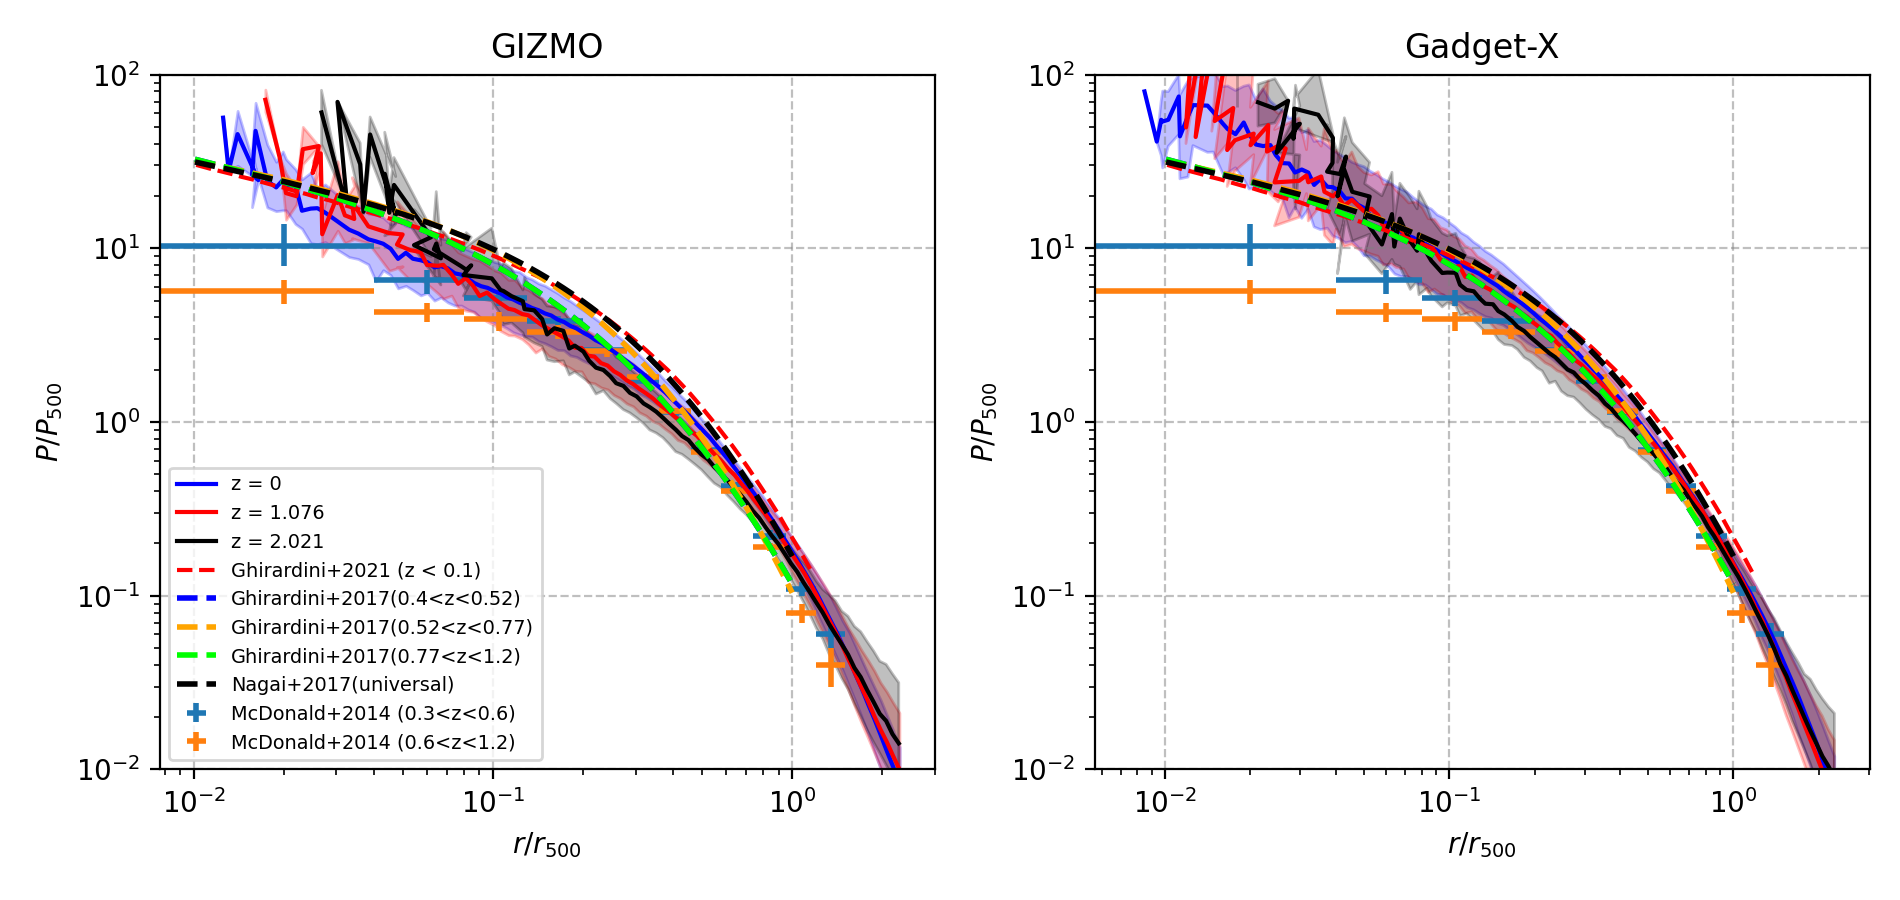

0.0
324
1.076147198677063
324

/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



2.0213561058044434
323

/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



0.0
324

/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-83-a57ebb52776f>:9: RuntimeWarning: divide by zero encountered in true_divide
  return P0 / ((c500*xx)**gama*(1 + (c500*xx)**alpha)**((beta-gama)/alpha))
<ipython-input-83-a57ebb52776f>:9: RuntimeWarning: divide by zero encountered in true_divide
  return P0 / ((c500*xx)**gama*(1 + (c500*xx)**alpha)**((beta-gama)/alpha))
<ipython-input-83-a57ebb52776f>:9: RuntimeWarning: divide by zero encountered in true_divide
  return P0 / ((c500*xx)**gama*(1 + (c500*xx)**alpha)**((beta-gama)/alpha))
<ipython-input-83-a57ebb52776f>:9: RuntimeWarning: divide by zero encountered in true_divide
  return P0 / ((c500*xx)**gama*(1 + (c500*xx)**alpha)**((beta-g


1.076147198677063
324

/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



2.0213561058044434
324

/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/python-3.8.5/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-83-a57ebb52776f>:9: RuntimeWarning: divide by zero encountered in true_divide
  return P0 / ((c500*xx)**gama*(1 + (c500*xx)**alpha)**((beta-gama)/alpha))
<ipython-input-83-a57ebb52776f>:9: RuntimeWarning: divide by zero encountered in true_divide
  return P0 / ((c500*xx)**gama*(1 + (c500*xx)**alpha)**((beta-gama)/alpha))
<ipython-input-83-a57ebb52776f>:9: RuntimeWarning: divide by zero encountered in true_divide
  return P0 / ((c500*xx)**gama*(1 + (c500*xx)**alpha)**((beta-gama)/alpha))
<ipython-input-83-a57ebb52776f>:9: RuntimeWarning: divide by zero encountered in true_divide
  return P0 / ((c500*xx)**gama*(1 + (c500*xx)**alpha)**((beta-g

In [90]:
#pressure
plt.figure(figsize  = (9.5,4.5))

plt.subplot(121)
#z = 0
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,128,'Pressure',324)
plt.plot(xmed,ymed,c='b',label = 'z = 0')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'b',alpha = 0.25)
#z = 1.076
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,95,'Pressure',324)
plt.plot(xmed,ymed,c='r',label = 'z = 1.076')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'r',alpha = 0.25)
#z = 2.021
xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,78,'Pressure',323)
plt.plot(xmed,ymed,c='k',label = 'z = 2.021')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'k',alpha = 0.25)

ob_Pressure()
plt.title('GIZMO')
plt.xlabel(r'$r/r_{500}$')
plt.ylabel(r'$P/P_{500}$')
plt.grid(c = 'grey', ls = '--', alpha = 0.5)
plt.ylim(1e-2,1e2)
plt.loglog()
plt.legend(fontsize = 'x-small')

plt.subplot(122)
#z = 0
xmed,ymed,yerr = cal_sta_profiles('G3X',G3Xd,128,'Pressure',324)
plt.plot(xmed,ymed,c='b',label = 'z = 0')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'b',alpha = 0.25)
#z = 1.076
xmed,ymed,yerr = cal_sta_profiles('G3X',G3Xd,95,'Pressure',324)
plt.plot(xmed,ymed,c='r',label = 'z = 1.076')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'r',alpha = 0.25)
#z = 2.021
xmed,ymed,yerr = cal_sta_profiles('G3X',G3Xd,78,'Pressure',324)
plt.plot(xmed,ymed,c='k',label = 'z = 2.021')
plt.fill_between(xmed,yerr[0],yerr[1],color = 'k',alpha = 0.25)


ob_Pressure()
plt.title('Gadget-X')
plt.xlabel(r'$r/r_{500}$')
plt.ylabel(r'$P/P_{500}$')
plt.grid(c = 'grey', ls = '--', alpha = 0.5)
plt.ylim(1e-2,1e2)
plt.loglog()

plt.tight_layout()

<IPython.core.display.Javascript object>


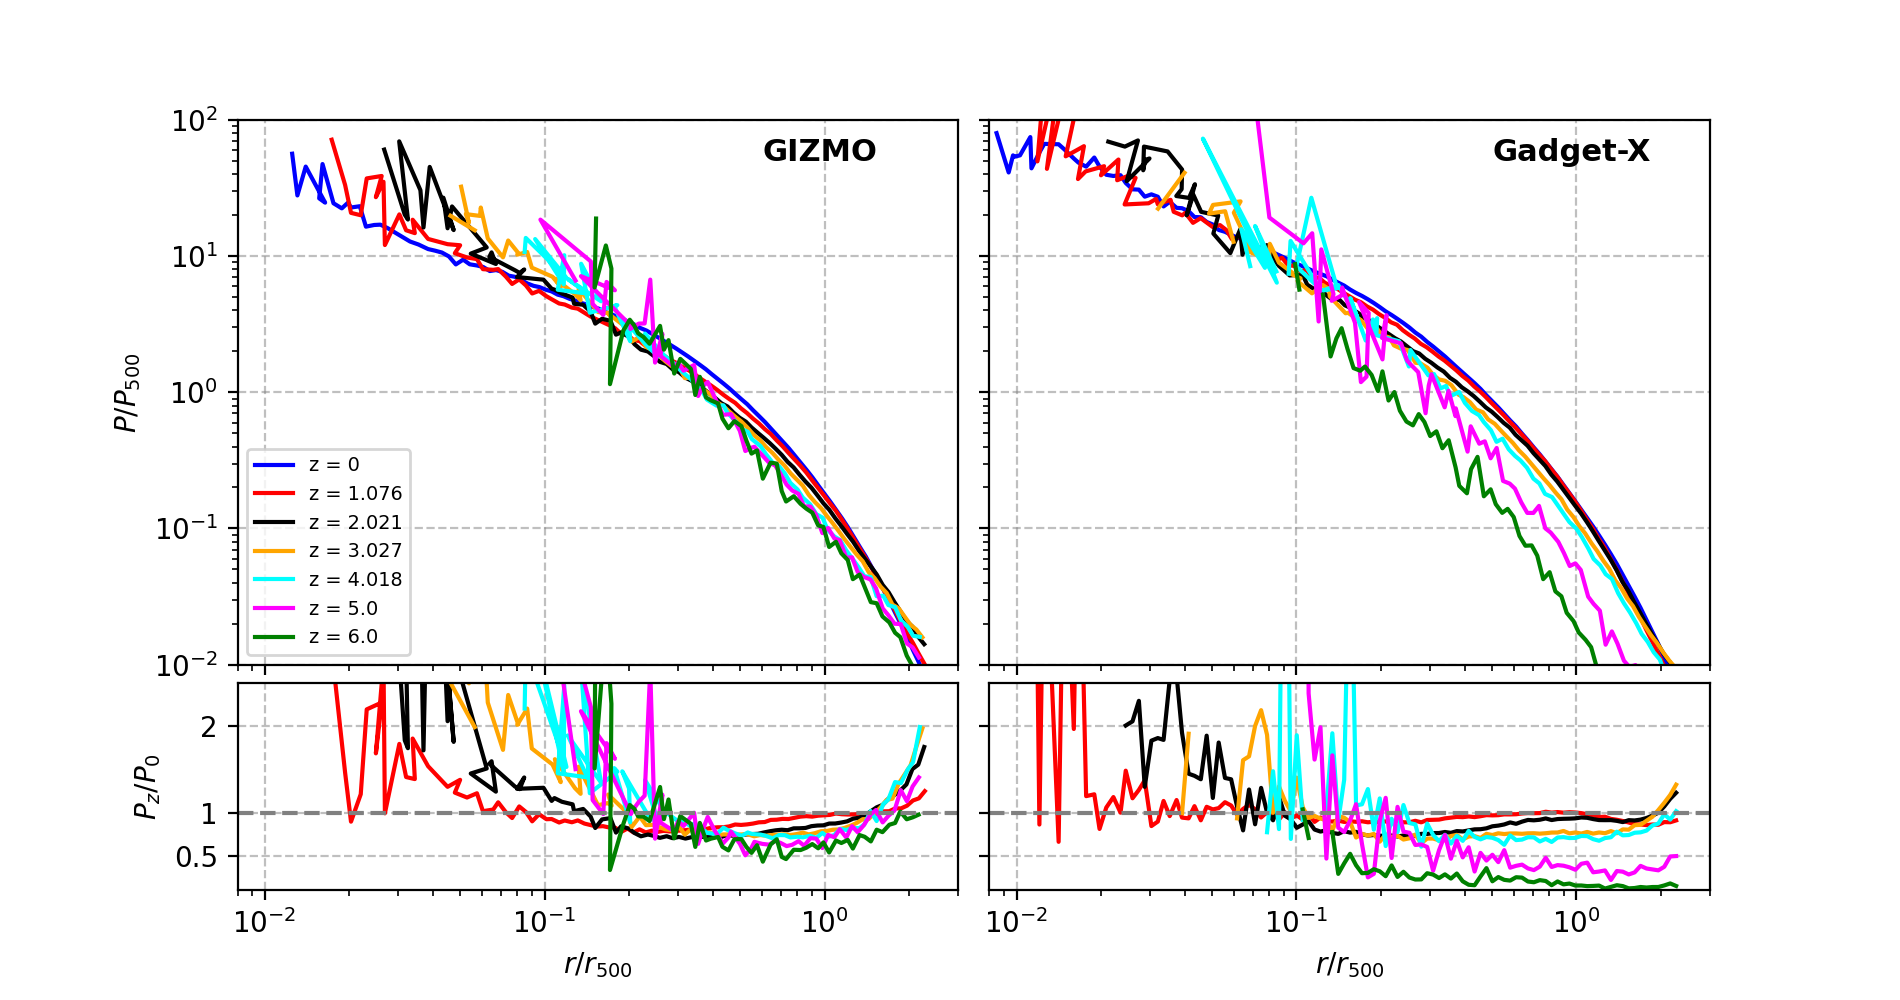

0.0
324
1.076147198677063
324

/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



2.0213561058044434
323

/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



3.0278635025024414
323

/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



4.017714977264404


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323
4.993260860443115
318

/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



5.993073463439941


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


306
0.0


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


324
1.076147198677063
324

/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



2.0213561058044434
324

/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



3.0278635025024414


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


323
4.017714977264404
323

/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



4.993260860443115


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


320
5.993073463439941


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


305


/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/qyli/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[]

In [10]:
#study evolution of gas density
from astropy.cosmology import FlatLambdaCDM
plt.figure(figsize = (9.5,5))
cosmo = FlatLambdaCDM(H0=67.77, Om0=0.307115)

#divide grids for figure
ax1 = plt.subplot2grid((7,8),(0,0),colspan = 4,rowspan = 5)
ax2 = plt.subplot2grid((7,8),(0,4),colspan = 4,rowspan = 5)
ax10 = plt.subplot2grid((7,8),(5,0),colspan = 4,rowspan = 2)
ax20 = plt.subplot2grid((7,8),(5,4),colspan = 4,rowspan = 2)

snapb = [128,95,78,65,55,47,40]
redb = ['z = 0','z = 1.076','z = 2.021','z = 3.027','z = 4.018','z = 5.0','z = 6.0']
colall = ['b','r','k','orange','cyan','magenta','g']
nGIZ = [324,324,323,323,323,318,306]
nG3X = [324,324,324,323,323,320,305]

for i in range(7):
    if i == 0:
        xmed0,ymed0,yerr = cal_sta_profiles('GIZ',GIZd,snapb[i],'Pressure',nGIZ[i])
        ax1.plot(xmed0,ymed0,label = redb[i],c=colall[i])
    else:
        xmed,ymed,yerr = cal_sta_profiles('GIZ',GIZd,snapb[i],'Pressure',nGIZ[i])
        ax1.plot(xmed,ymed,label = redb[i],c=colall[i])
        ax10.plot(xmed,ymed/ymed0,c=colall[i])
    # plt.fill_between(xmed,yerr[0],yerr[1],alpha = 0.25)

ax10.grid(c = 'grey', ls = '--', alpha = 0.5)
ax10.axhline(1,c='grey',ls='--')

ax1.text(0.6,50,'GIZMO',weight = 'bold',size = 11)
ax1.set_ylabel(r'$P/P_{500}$')
ax1.loglog()
ax1.legend(fontsize = 'x-small', loc = 3)
ax1.set_xticklabels([])
ax1.set_ylim(1e-2,1e2)
ax1.set_xlim(0.008,3)
ax1.grid(c = 'grey', ls = '--', alpha = 0.5)
ax10.set_xscale('log')
ax10.set_xlim(0.008,3)
ax10.set_ylim(0.1,2.5)
ax10.set_xlabel(r'$r/r_{500}$')
ax10.set_ylabel(r'$P_z/P_0$')
ax10.set_yticks([0.5,1,2])
ax10.set_yticklabels([0.5,1,2])

#Gadget-X
for i in range(7):
    if i == 0:
        xmed0,ymed0,yerr = cal_sta_profiles('G3X',G3Xd,snapb[i],'Pressure',nG3X[i])
        ax2.plot(xmed0,ymed0,label = redb[i],c=colall[i])
    else:
        xmed,ymed,yerr = cal_sta_profiles('G3X',G3Xd,snapb[i],'Pressure',nG3X[i])
        ax2.plot(xmed,ymed,label = redb[i],c=colall[i])
        ax20.plot(xmed0,ymed/ymed0,c=colall[i])
    # plt.fill_between(xmed,yerr[0],yerr[1],alpha = 0.25)

ax20.grid(c = 'grey', ls = '--', alpha = 0.5)
ax20.axhline(1,c='grey',ls='--')
ax2.text(0.5,50,'Gadget-X',weight = 'bold',size = 11)

ax2.loglog()
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.grid(c = 'grey', ls = '--', alpha = 0.5)
ax2.set_ylim(1e-2,1e2)
ax2.set_xlim(0.008,3)

ax20.set_xscale('log')
ax20.set_xlim(0.008,3)
ax20.set_ylim(0.1,2.5)
ax20.set_xlabel(r'$r/r_{500}$')
ax20.set_yticks([0.5,1,2])
ax20.set_yticklabels([])
# plt.savefig('./figs/Gdens.pdf')
# plt.tight_layout()